# Prefect

## Local

### Theory

-

### Practice

#### Hello, world flow

Here we're building the simplest possible flow - the simplest logic and the simplest deployment.

In [1]:
from prefect import Flow, task

@task
def echo(text):
    return text

with Flow("Hello, world - local") as flow:
    hello_world = echo("Hello, world!")

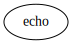

In [2]:
flow.visualize()

In [3]:
state = flow.run()

[2022-01-09 23:08:24+0000] INFO - prefect.FlowRunner | Beginning Flow run for 'My first Prefect flow'
[2022-01-09 23:08:24+0000] INFO - prefect.TaskRunner | Task 'echo': Starting task run...
[2022-01-09 23:08:25+0000] INFO - prefect.TaskRunner | Task 'echo': Finished task run for task with final state: 'Success'
[2022-01-09 23:08:25+0000] INFO - prefect.FlowRunner | Flow run SUCCESS: all reference tasks succeeded


Check the result:

In [4]:
task_ref = flow.get_tasks()[0]
state.result[task_ref]._result

<Result: 'Hello, world!'>

#### A slightly more complex flow

Still with the simplest possible deployment.

In [3]:
from prefect import Flow, task

@task
def read_x():
    return 1

@task
def read_y():
    return 2

@task
def add(x, y):
    return x + y

with Flow("Add - local") as flow:
    x = read_x()
    y = read_y()
    total = add(x, y)

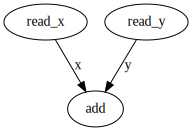

In [4]:
flow.visualize()

In [5]:
state = flow.run()

[2022-01-16 12:28:34+0000] INFO - prefect.FlowRunner | Beginning Flow run for 'Add - local'
[2022-01-16 12:28:34+0000] INFO - prefect.TaskRunner | Task 'read_x': Starting task run...
[2022-01-16 12:28:36+0000] INFO - prefect.TaskRunner | Task 'read_x': Finished task run for task with final state: 'Success'
[2022-01-16 12:28:36+0000] INFO - prefect.TaskRunner | Task 'read_y': Starting task run...
[2022-01-16 12:28:36+0000] INFO - prefect.TaskRunner | Task 'read_y': Finished task run for task with final state: 'Success'
[2022-01-16 12:28:36+0000] INFO - prefect.TaskRunner | Task 'add': Starting task run...
[2022-01-16 12:28:36+0000] INFO - prefect.TaskRunner | Task 'add': Finished task run for task with final state: 'Success'
[2022-01-16 12:28:36+0000] INFO - prefect.FlowRunner | Flow run SUCCESS: all reference tasks succeeded


In [7]:
task_ref = flow.get_tasks()[2]
state.result[task_ref]._result

<Result: 3>

### Check your understanding
- what is a flow?
- what is a task?
- would using Prefect be a good idea if you only had 5 daily scripts to run?
- can you come up with a use case where you could use Prefect (personal or work)?

### Exercise <a id='excercise_1'></a>
Write a flow that:
- reads two files
- combines both inputs and writes it to the console using the [Prefect logger](https://docs.prefect.io/core/concepts/logging.html#logging-configuration)

It should use two task instances for reading the files -- note that both could use the same task, eg. `read_file()`. 

**Bonus:** use [task mapping](https://docs.prefect.io/core/concepts/mapping.html#prefect-approach) to map the `read_file()` task onto two files

In [23]:
# your flow here

### Solution

In [25]:
from prefect import Flow, task
from typing import List

import prefect

@task
def read_file(path: str) -> str:
    with open(path) as f:
        return f.read()

@task
def concat_files_and_diplay(file_contents: List[str]):
    
    logger = prefect.context.get("logger")
    
    concatenated = "".join(file_contents)
    logger.info(f"Concatenated text: {concatenated}") 

with Flow("Concart files - local") as flow:
    file_1 = read_file("file_1.txt")
    file_2 = read_file("file_2.txt")
    concatenated = concat_files_and_diplay(file_contents=[file_1, file_2])

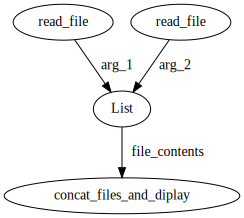

In [26]:
flow.visualize()

In [27]:
flow.run()

[2022-01-16 12:54:46+0000] INFO - prefect.FlowRunner | Beginning Flow run for 'Concart files - local'
[2022-01-16 12:54:46+0000] INFO - prefect.TaskRunner | Task 'read_file': Starting task run...
[2022-01-16 12:54:46+0000] INFO - prefect.TaskRunner | Task 'read_file': Finished task run for task with final state: 'Success'
[2022-01-16 12:54:46+0000] INFO - prefect.TaskRunner | Task 'read_file': Starting task run...
[2022-01-16 12:54:46+0000] INFO - prefect.TaskRunner | Task 'read_file': Finished task run for task with final state: 'Success'
[2022-01-16 12:54:46+0000] INFO - prefect.TaskRunner | Task 'List': Starting task run...
[2022-01-16 12:54:46+0000] INFO - prefect.TaskRunner | Task 'List': Finished task run for task with final state: 'Success'
[2022-01-16 12:54:46+0000] INFO - prefect.TaskRunner | Task 'concat_files_and_diplay': Starting task run...
[2022-01-16 12:54:46+0000] INFO - prefect.concat_files_and_diplay | Concatenated text: Hello, world!
[2022-01-16 12:54:46+0000] INFO -

<Success: "All reference tasks succeeded.">

## Sandbox

### Theory

We're going to keep the "Hello, world" flow logic the same, but now we'll prepare the flow for running it from the cloud.

#### Storage
In this workshop, we're using [Docker Agent](https://docs.prefect.io/orchestration/agents/docker.html), which creates a Docker container for each flow run. This Docker container does not have access to a locally stored flow (which is the default if we don't specify `Flow`'s `storage`), and so we need another way to pass the flow to the agent.  
**This is a common theme with remote execution:** where do I store the code/data/artifacts, so that the remote server can use them? In this case, since we only need the Prefect Agent to access our flow's code, it's intuitive to store it in a code repository such as GitHub.

#### Labels
In order to "assign" a flow to a Prefect Agent, we label both, and Prefect runs the flows in the agents with the same label as the flow for us. For example, we may have a label "gpu", and an agent running on a GPU optimized AWS server with the same label. Then, when deploying GPU-heavy flows, we can tell Prefect to run them on the GPU-optimized machine. Below, we will use labels in order to implement staging environments.  
For the purpose of this workshop, we will only use `sbx` (sandbox) and `dev` (development). In production, typically another two environments would be present - `tst` (test) and `prod` (production).

### Practice

#### Add storage and label

In [5]:
from prefect import Flow, task
from prefect.run_configs import DockerRun
from prefect.storage import GitHub

ELT_WORKSHOP_REPO = "dyvenia/elt_workshop"
STORAGE = GitHub(repo=ELT_WORKSHOP_REPO, path="elt_workshop/prefect/hello_world_sbx.py")


@task
def echo(text):
    return text


with Flow(
    "Hello, world - sandbox", storage=STORAGE, run_config=DockerRun(labels=["sbx"])
) as flow:
    hello_world = echo("Hello, world!")


#### Test locally

In [5]:
state = flow.run()

[2022-01-09 21:49:50+0000] INFO - prefect.FlowRunner | Beginning Flow run for 'My first Prefect flow'
[2022-01-09 21:49:50+0000] INFO - prefect.TaskRunner | Task 'echo': Starting task run...
[2022-01-09 21:49:50+0000] INFO - prefect.TaskRunner | Task 'echo': Finished task run for task with final state: 'Success'
[2022-01-09 21:49:50+0000] INFO - prefect.FlowRunner | Flow run SUCCESS: all reference tasks succeeded


<div class="alert alert-block alert-info">
<b>Note</b> the flow runs just the same. It doens't pull the flow from storage when ran locally.
</div>

#### Register the flow in Prefect Cloud

##### Create a project
Think of it as a "folder" for flows in Prefect Cloud. Projects can also serve as environments for flows.

In [31]:
!prefect create project "sbx"

sbx created


##### Register the flow in Prefect Cloud

In [6]:
flow.register(project_name="sbx")

Flow URL: https://cloud.prefect.io/trymzet/flow/ae7e2d8f-9bcf-4a84-80f4-de0e52fc300a
 └── ID: d639349a-f31b-4c30-82c0-66c72757b959
 └── Project: elt_workshop
 └── Labels: []


'd639349a-f31b-4c30-82c0-66c72757b959'

<div class="alert alert-block alert-info">
Use Chrome to open the above link as Prefect UI doesn't look well in Firefox
</div>

### Check your understanding
- why do we need to specify the flow's storage when running it from the cloud?
- where are flows we triggered in Prefect Cloud actually running?

### Exercise
- deploy your file reader flow [Exercise 1.1.4](#excercise_1) to Prefect Cloud
- explain why the flow is failing and how would you fix it

In [24]:
# your flow here

In [ ]:
flow.visualize()

In [ ]:
flow.run()

### Solution

In [28]:
from typing import List

import prefect
from prefect import Flow, task
from prefect.storage import GitHub

ELT_WORKSHOP_REPO = "dyvenia/elt_workshop"
STORAGE = GitHub(
    repo=ELT_WORKSHOP_REPO,
    path="elt_workshop/prefect/concat_files_sbx.py"
)


@task
def read_file(path: str) -> str:
    with open(path) as f:
        return f.read()


@task
def concat_files_and_diplay(file_contents: List[str]):

    logger = prefect.context.get("logger")

    concatenated = "".join(file_contents)
    logger.info(f"Concatenated text: {concatenated}")


with Flow("Concat files - sbx", storage=STORAGE) as flow:
    file_1 = read_file("file_1.txt")
    file_2 = read_file("file_2.txt")
    concatenated = concat_files_and_diplay(file_contents=[file_1, file_2])


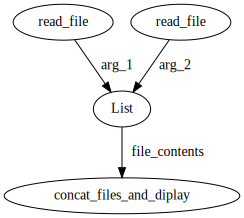

In [29]:
flow.visualize()

In [30]:
flow.run()

[2022-01-16 12:55:06+0000] INFO - prefect.FlowRunner | Beginning Flow run for 'Concat files - sbx'
[2022-01-16 12:55:06+0000] INFO - prefect.TaskRunner | Task 'read_file': Starting task run...
[2022-01-16 12:55:06+0000] INFO - prefect.TaskRunner | Task 'read_file': Finished task run for task with final state: 'Success'
[2022-01-16 12:55:06+0000] INFO - prefect.TaskRunner | Task 'read_file': Starting task run...
[2022-01-16 12:55:06+0000] INFO - prefect.TaskRunner | Task 'read_file': Finished task run for task with final state: 'Success'
[2022-01-16 12:55:06+0000] INFO - prefect.TaskRunner | Task 'List': Starting task run...
[2022-01-16 12:55:06+0000] INFO - prefect.TaskRunner | Task 'List': Finished task run for task with final state: 'Success'
[2022-01-16 12:55:06+0000] INFO - prefect.TaskRunner | Task 'concat_files_and_diplay': Starting task run...
[2022-01-16 12:55:06+0000] INFO - prefect.concat_files_and_diplay | Concatenated text: Hello, world!
[2022-01-16 12:55:06+0000] INFO - pr

<Success: "All reference tasks succeeded.">

In [32]:
!prefect create project "sbx"

sbx created


In [33]:
flow.register(project_name="sbx")

/home/viadot/.local/lib/python3.8/site-packages/prefect/core/flow.py:1727: UserWarning: No result handler was specified on your Flow. Cloud features such as input caching and resuming task runs from failure may not work properly.
  registered_flow = client.register(


Flow URL: https://cloud.prefect.io/trymzet/flow/e4fed804-4394-4b8c-af4e-4a0b5fbd5584
 └── ID: 02756764-6369-4961-aa4e-c452211305ec
 └── Project: sbx
 └── Labels: []


'02756764-6369-4961-aa4e-c452211305ec'

<div class="alert alert-block alert-warning">
Remember to push concat_files_sbx.py to your fork before running from Prefect Cloud.
</div>

## Dev

### Theory

When deploying to the dev environment, we want to add several components:

1. Specify a reproducible environment in which the flow will be executed  
Because reproducibility is very important. 

By default, Docker Agent uses the `prefecthq/prefect:latest` image.

2. Add alerts in case our flow failure  
Allows us to take immediate action.

3. Add scheduling  
We usually want to automate repeatable tasks

For point no. 2, we will need to do a bit of set up and config work:
> These instructions are intentionally left high-level -- you're welcome to create a PR that changes these vague instructions into recipes for extra points!
1. [Set up a Slack workspace](https://slack.com/help/articles/206845317-Create-a-Slack-workspace)
2. Follow [this](https://prefect-slack.appspot.com/) link to connect Prefect notifications to a Slack channel.
3. Add the webhook url to your Prefect Cloud secrets with the name `SLACK_WEBHOOK_URL`

### Practice

In [49]:
from prefect import Flow, task
from prefect.engine.state import Failed
from prefect.run_configs.docker import DockerRun
from prefect.schedules import Schedule
from prefect.schedules.clocks import CronClock
from prefect.storage import GitHub
from prefect.utilities.notifications import slack_notifier

ELT_WORKSHOP_REPO = "dyvenia/elt_workshop"
STORAGE = GitHub(
    repo=ELT_WORKSHOP_REPO,
    path="elt_workshop/prefect/hello_world_dev.py"
)
RUN_CONFIG = DockerRun(
    image="prefecthq/prefect:0.15.11-python3.9",
    env={"HTTP_PROXY": "SOME_IP_ADDR"},
    labels=["dev"],
)
SLACK_NOTIFIER = slack_notifier(only_states=[Failed])
SCHEDULE = Schedule(clocks=[CronClock("* */12 * * *")])


@task
def echo(text):
    return text


with Flow(
    "Hello, world - dev",
    storage=STORAGE,
    run_config=RUN_CONFIG,
    state_handlers=[SLACK_NOTIFIER],
    schedule=SCHEDULE,
) as flow:
    hello_world = echo("Hello, world!")

In [11]:
!prefect create project "dev"

dev created


In [4]:
flow.register(project_name="dev")

Flow URL: https://cloud.prefect.io/trymzet/flow/9110343e-0e49-48b0-91d7-e92f8525bb29
 └── ID: 853706f0-3833-4246-a066-6dcce9888a74
 └── Project: dev
 └── Labels: ['dev']


'853706f0-3833-4246-a066-6dcce9888a74'

<div class="alert alert-block alert-warning">
    If you click the link and go to the flow now, you will see an alert next to "labels". <br/><br/>
    This is because the agent we've been using so far does not have the "dev" label. In order to fix this, we need to start another agent with a "dev" label. Run `start_prefect_agent_dev.sh` to do that.
</div>

### Understanding
- why is pinning the version of the Docker image important? What could happen if we don't pin it and simply use `latest`?

### Exercise

Checking out notifications
- add a task that raises an exeption (you can simply do `raise ValueError`) to the above flow
- deploy it
- confirm that a Slack notification is sent on flow failure
- fix the flow, change the schedule to "every 2 minutes", and redeploy
- confirm the flow is running on schedule as expected

<div class="alert alert-block alert-info">
Remember to disable the flow's schedule in the "flows" tab after completing the exercise.
</div>

In [35]:
# your flow

In [ ]:
flow.visualize()

In [ ]:
flow.run()

### Solution

In [50]:
from prefect import Flow, task
from prefect.engine.state import Failed
from prefect.run_configs.docker import DockerRun
from prefect.schedules import Schedule
from prefect.schedules.clocks import CronClock
from prefect.storage import GitHub
from prefect.utilities.notifications import slack_notifier

ELT_WORKSHOP_REPO = "dyvenia/elt_workshop"
STORAGE = GitHub(
    repo=ELT_WORKSHOP_REPO, path="elt_workshop/prefect/hello_world_dev_failing.py"
)
RUN_CONFIG = DockerRun(
    image="prefecthq/prefect:0.15.11-python3.9",
    env={"HTTP_PROXY": "SOME_IP_ADDR"},
    labels=["dev"],
)
SLACK_NOTIFIER = slack_notifier(only_states=[Failed])
SCHEDULE = Schedule(clocks=[CronClock("* */12 * * *")])


@task
def echo(text):
    return text

@task
def failing_task():
    raise ValueError


with Flow(
    "Hello, world - dev - failing",
    storage=STORAGE,
    run_config=RUN_CONFIG,
    state_handlers=[SLACK_NOTIFIER],
    schedule=SCHEDULE,
) as flow:
    hello_world = echo("Hello, world!")
    fail = failing_task()

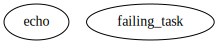

In [51]:
flow.visualize()

<div class="alert alert-block alert-info">
Note that below will not work. Comment out the `state_handlers` and `schedule` lines to test locally.
</div>

In [48]:
# flow.run()

In [11]:
!prefect create project "dev"

dev created


In [52]:
flow.register(project_name="dev")

Flow URL: https://cloud.prefect.io/trymzet/flow/6a990c19-017b-4473-8b9c-3f2fea216783
 └── ID: f456ab37-b90d-4a95-ac63-8ce7df2ad6ef
 └── Project: dev
 └── Labels: ['dev']


'f456ab37-b90d-4a95-ac63-8ce7df2ad6ef'

# Airbyte

Now that we understand how Prefect works and how we can use it to schedule and run flows, we will use that knowledge to build our first ELT pipeline. 

We will use Prefect to orchestrate an Airbyte synchronization job.

## Google Sheets -> Local JSON

### Configure Google Sheet source
[LINK](https://docs.airbyte.com/integrations/sources/google-sheets#setup-guide-1)

<div class="alert alert-block alert-info">
Make sure to choose "Service Account Key Authentication" in the `credentials` dropdown after you select Source type. 
</div>

### Configure Local JSON destination
Note that the actual file destination will be `/tmp/airbyte_local` + Destination Path, eg. if we specify Destination Path as `workshop/sheets`, the JSON files will appear in `/tmp/airbyte_local/workshop/sheets`.

### Configure Google Sheets - > local JSON connection
In Airbyte: Sources -> your Google Sheet source -> Add destination -> your local JSON destination.

### AirbyteConnectionTask workaround
Here I define a custom Prefect task, `AirbyteConnectionTask2`. This is needed until the PR to Prefect is accepted. I cleaned up the messy logs from the original Prefect task and added some improvements.

You can hide below cell again after running.

In [83]:
from time import sleep
import uuid

import requests
from requests import RequestException

from prefect import Task
from prefect.engine.signals import FAIL
from prefect.utilities.tasks import defaults_from_attrs
import logging
import re
from typing import List, Tuple


class ConnectionNotFoundException(Exception):
    pass


class AirbyteServerNotHealthyException(Exception):
    pass


class JobNotFoundException(Exception):
    pass


class AirbyteConnectionTask2(Task):
    """
    Task for triggering Airbyte Connections, where "A connection is
    a configuration for syncing data between a source and a destination."
    For more information refer to the
    [Airbyte docs](https://docs.airbyte.io/understanding-airbyte/connections)
    This task assumes that the Airbyte Open-Source, since "For
    Airbyte Open-Source you don't need the API Token for
    Authentication! All endpoints are possible to access using the
    API without it."
    For more information refer to the [Airbyte docs](https://docs.airbyte.io/api-documentation)
    Args:
        - airbyte_server_host (str, optional): Hostname of Airbyte server where connection is configured.
            Defaults to localhost.
        - airbyte_server_port (str, optional): Port that the Airbyte server is listening on.
            Defaults to 8000.
        - airbyte_api_version (str, optional): Version of Airbyte API to use to trigger connection sync.
            Defaults to v1.
        - connection_id (str, optional): Default connection id to
            use for sync jobs, if none is specified to `run`.
        - **kwargs (Any, optional): additional kwargs to pass to the
            base Task constructor
    """

    # Connection statuses
    CONNECTION_STATUS_ACTIVE = "active"
    CONNECTION_STATUS_INACTIVE = "inactive"
    CONNECTION_STATUS_DEPRECATED = "deprecated"

    # Job statuses
    # pending┃running┃incomplete┃failed┃succeeded┃cancelled
    JOB_STATUS_SUCCEEDED = "succeeded"
    JOB_STATUS_FAILED = "failed"
    JOB_STATUS_PENDING = "pending"
    
    # Attempt statuses
    ATTEMPT_STATUS_SUCCEEDED = "succeeded"
    ATTEMPT_STATUS_FAILED = "failed"
    ATTEMPT_STATUS_RUNNING = "running"
    

    def __init__(
        self,
        airbyte_server_host: str = "localhost",
        airbyte_server_port: int = 8000,
        airbyte_api_version: str = "v1",
        connection_id: str = None,
        **kwargs,
    ):
        self.airbyte_server_host = airbyte_server_host
        self.airbyte_server_port = airbyte_server_port
        self.airbyte_api_version = airbyte_api_version
        self.connection_id = connection_id
        super().__init__(**kwargs)

    def _check_health_status(self, session: requests.Session) -> bool:
        get_connection_url = self.airbyte_base_url + "/health/"
        try:
            response = session.get(get_connection_url)
            health_status = response.json()["db"]
            if not health_status:
                raise AirbyteServerNotHealthyException(
                    f"Airbyte Server health status: {health_status}"
                )
            return True
        except RequestException as e:
            raise AirbyteServerNotHealthyException(e)
            
    def _get_connection_source_and_dest(self, session: requests.Session) -> Tuple[str, str]:
        """Get source and destination names for the connection ID.
        Note `web_backend` in the URL"""
        get_connection_url = self.airbyte_base_url + "/web_backend/connections/get/"
        try:
            response = session.post(
                get_connection_url, json={"connectionId": self.connection_id}
            )
            source = response.json()["source"]["name"]
            source_class = response.json()["source"]["sourceName"]
            destination = response.json()["destination"]["name"]
            destination_class = response.json()["destination"]["destinationName"]
            full_source_name = source_class + ": " + source
            full_destination_name = destination_class + ": " + destination
            return full_source_name, full_destination_name
        except RequestException as e:
            raise AirbyteServerNotHealthyException(e)

    def _get_connection_status(self, session: requests.Session) -> str:
        get_connection_url = self.airbyte_base_url + "/connections/get/"
        
        # TODO - Missing authentication because Airbyte servers currently do not support authentication
        try:
            response = session.post(
                get_connection_url, json={"connectionId": self.connection_id}
            )

            # check whether a schedule exists ...
            schedule = response.json()["schedule"]
            if schedule:
                self.logger.warning("Found existing Connection schedule, removing ...")

                # mandatory fields for Connection update ...
                sync_catalog = response.json()["syncCatalog"]
                connection_status = response.json()["status"]

                update_connection_url = self.airbyte_base_url + "/connections" "/update/"
                response2 = session.post(
                    update_connection_url,
                    json={
                        "connectionId": self.connection_id,
                        "syncCatalog": sync_catalog,
                        "schedule": None,
                        "status": connection_status,
                    },
                )

                if response2.status_code == 200:
                    self.logger.info("Schedule removed.")
                else:
                    self.logger.warning("Schedule not removed.")
                    self.logger.warning(response2.json())

            connection_status = response.json()["status"]
            return connection_status
        except RequestException as e:
            raise AirbyteServerNotHealthyException(e)

    def _trigger_manual_sync_connection(self, session: requests.Session) -> Tuple[int, int]:
        """
        Trigger a manual sync of the Connection, see:
        https://airbyte-public-api-docs.s3.us-east-2.amazonaws.com/rapidoc
        -api-docs.html#post-/v1/connections/sync
        Args:
            session: requests session with which to make call to Airbyte server
        Returns: job_id, job_created_at - timestamp of sync job creation
        """
        get_connection_url = self.airbyte_base_url + "/connections/sync/"

        # TODO - missing authentication ...
        try:
            response = session.post(
                get_connection_url, json={"connectionId": self.connection_id}
            )
            if response.status_code == 200:
                job_id = response.json()["job"]["id"]
                job_created_at = response.json()["job"]["createdAt"]
                return job_id, job_created_at
            elif response.status_code == 404:
                raise ConnectionNotFoundException(
                    f"Connection {connection_id} not found, please double "
                    f"check the connection_id ..."
                )
        except RequestException as e:
            raise AirbyteServerNotHealthyException(e)
    
    @staticmethod
    def _escape_ansi(line: str) -> str:
        ansi_escape = re.compile(r'(?:\x1B[@-_]|[\x80-\x9F])[0-?]*[ -/]*[@-~]')
        return ansi_escape.sub('', line)
    
    def _get_stripped_logger(self):
        """Helper method for _log_airbyte_logs()"""
        root_logger = logging.getLogger("prefect")
        
        handler = [h for h in root_logger.handlers if type(h) == logging.StreamHandler][0]
        prev_formatter = handler.formatter
        formatter = logging.Formatter(fmt='%(message)s')
        handler.setFormatter(formatter)
        
        stripped_logger = root_logger.getChild(self.name)
        
        return stripped_logger, prev_formatter
    
    def _recover_prefect_logger(self, prev_formatter: logging.Formatter) -> None:
        """Helper method for _log_airbyte_logs()"""
        root_logger = logging.getLogger("prefect")
        
        handler = [h for h in root_logger.handlers if type(h) == logging.StreamHandler][0]
        handler.setFormatter(prev_formatter)
    
    def _log_airbyte_logs(self, logs: List[str]) -> None:
        """Take a list of Airbyte logs and log them with the Prefect logger"""
        logger, prev_formatter = self._get_stripped_logger()
        for log in logs:
            log_escaped = self._escape_ansi(log)
            logger.debug(log_escaped)
        self._recover_prefect_logger(prev_formatter)

    def _get_job_status(
        self, session: requests.Session, job_id: int
    ) -> Tuple[str, int, int]:
        get_connection_url = self.airbyte_base_url + "/jobs/get/"
        try:
            response = session.post(get_connection_url, json={"id": job_id})
            if response.status_code == 200:
                job_status = response.json()["job"]["status"]
                
                if job_status == self.JOB_STATUS_SUCCEEDED:
                    attempts = response.json()["attempts"]
                    successful_attempt = [
                        a for a in attempts if a["attempt"]["status"] == self.ATTEMPT_STATUS_SUCCEEDED
                    ][0]

                    self._log_airbyte_logs(successful_attempt["logs"]["logLines"])
                                     
                job_created_at = response.json()["job"]["createdAt"]
                job_updated_at = response.json()["job"]["updatedAt"]
                return job_status, job_created_at, job_updated_at
            elif response.status_code == 404:
                self.logger.error(f"Job {job_id} not found...")
                raise JobNotFoundException(f"Job {job_id} not found...")
        except RequestException as e:
            raise AirbyteServerNotHealthyException(e)

    @defaults_from_attrs(
        "airbyte_server_host",
        "airbyte_server_port",
        "airbyte_api_version",
        "connection_id",
    )
    def run(
        self,
        airbyte_server_host: str = None,
        airbyte_server_port: int = None,
        airbyte_api_version: str = None,
        connection_id: str = None,
        display_airbyte_logs: bool = None,
        poll_interval_s: int = 15,
    ) -> dict:
        """
        Task run method for triggering an Airbyte Connection.
        *It is assumed that the user will have previously configured
        a Source & Destination into a Connection.*
        e.g. MySql -> CSV
        An invocation of `run` will attempt to start a sync job for
        the specified `connection_id` representing the Connection in
        Airbyte.
        `run` will poll Airbyte Server for the Connection status and
        will only complete when the sync has completed or
        when it receives an error status code from an API call.
        Args:
            - airbyte_server_host (str, optional): Hostname of Airbyte server where connection is
                configured. Will overwrite the value provided at init if provided.
            - airbyte_server_port (str, optional): Port that the Airbyte server is listening on.
                Will overwrite the value provided at init if provided.
            - airbyte_api_version (str, optional): Version of Airbyte API to use to trigger connection
                sync. Will overwrite the value provided at init if provided.
            - connection_id (str, optional): if provided,
                will overwrite the value provided at init.
            - poll_interval_s (int, optional): this task polls the
                Airbyte API for status, if provided this value will
                override the default polling time of 15 seconds.
        Returns:
            - dict: connection_id (str) and succeeded_at (timestamp str)
        """
        
        if not connection_id:
            raise ValueError("`connection_id` *must* be provided.")

        try:
            uuid.UUID(connection_id)
        except (TypeError, ValueError):
            raise ValueError(
                "Parameter `connection_id` *must* be a valid UUID \
                i.e. 32 hex characters, including hyphens."
            )
            
        self.connection_id = connection_id

        # see https://airbyte-public-api-docs.s3.us-east-2.amazonaws.com
        # /rapidoc-api-docs.html#overview
        self.airbyte_base_url = (
            f"http://{airbyte_server_host}:"
            f"{airbyte_server_port}/api/{airbyte_api_version}"
        )

        session = requests.Session()
        self._check_health_status(session)

        connection_status = self._get_connection_status(session)
        if connection_status == self.CONNECTION_STATUS_ACTIVE:
            # Trigger manual sync on the Connection ...
            source, destination = self._get_connection_source_and_dest(session)
            self.logger.info(f"Triggering sync '{source}' -> '{destination}'...")
                
            job_id, job_created_at = self._trigger_manual_sync_connection(session)

            job_status = self.JOB_STATUS_PENDING

            while job_status not in [self.JOB_STATUS_FAILED, self.JOB_STATUS_SUCCEEDED]:
                job_status, job_created_at, job_updated_at = self._get_job_status(
                    session, job_id
                )

                if job_status == self.JOB_STATUS_SUCCEEDED:
                    self.logger.info(f"Job {job_id} succeeded.")
                elif job_status == self.JOB_STATUS_FAILED:
                    self.logger.error(f"Job {job_id} failed.")
                else:
                    # wait for next poll interval
                    sleep(poll_interval_s)

            return {
                "connection_id": connection_id,
                "status": connection_status,
                "job_status": job_status,
                "job_created_at": job_created_at,
                "job_updated_at": job_updated_at,
            }
        elif connection_status == self.CONNECTION_STATUS_INACTIVE:
            self.logger.error(
                f"Please enable the Connection {connection_id} in Airbyte Server."
            )
            raise FAIL(
                f"Please enable the Connection {connection_id} in Airbyte Server."
            )
        elif connection_status == self.CONNECTION_STATUS_DEPRECATED:
            self.logger.error(f"Connection {connection_id} is deprecated.")
            raise FAIL(f"Connection {connection_id} is deprecated.")

In [84]:
t = AirbyteConnectionTask2(
    max_retries=3,
    retry_delay=timedelta(seconds=10),
    airbyte_server_host="webapp",
    airbyte_server_port=80,
    airbyte_api_version="v1",
    connection_id="c9871fe3-b022-4e08-a692-1e02af90732d"
    
)
session = requests.Session()
t.airbyte_base_url = (
            f"http://webapp:80/api/v1"
        )
t._get_connection_source_and_dest(session)

('Google Sheets: fav_things', 'Local JSON: fav_things')

### Write flow

In [85]:
from datetime import timedelta

from prefect import Flow, Parameter, task
from prefect.run_configs.docker import DockerRun
from prefect.storage.local import Local
from prefect.tasks.airbyte.airbyte import AirbyteConnectionTask

RUN_CONFIG = DockerRun(
    image="prefecthq/prefect:0.15.11-python3.9",
    env={"SOME_VAR": "value"},
    labels=["dev"],
)

sync_airbyte_connection = AirbyteConnectionTask2(
    max_retries=3,
    retry_delay=timedelta(seconds=10),
    airbyte_server_host="webapp",
    airbyte_server_port=80,
    airbyte_api_version="v1"
)


with Flow("Sync pokeAPI to Metabase - local", storage=Local(), run_config=RUN_CONFIG) as flow:
    # Airbyte connection strings
    airbyte_connections = Parameter("AIRBYTE_CONNECTION_IDS")

    # Sync
    sync_all = sync_airbyte_connection.map(connection_id=airbyte_connections)

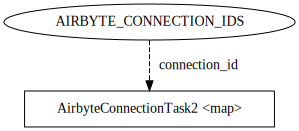

In [86]:
flow.visualize()

In [87]:
AIRBYTE_CONNECTION_IDS = ["c9871fe3-b022-4e08-a692-1e02af90732d"]

flow.run(AIRBYTE_CONNECTION_IDS=AIRBYTE_CONNECTION_IDS)

[2022-01-16 16:30:06+0000] INFO - prefect.FlowRunner | Beginning Flow run for 'Sync pokeAPI to Metabase - local'
[2022-01-16 16:30:06+0000] INFO - prefect.TaskRunner | Task 'AIRBYTE_CONNECTION_IDS': Starting task run...
[2022-01-16 16:30:06+0000] INFO - prefect.TaskRunner | Task 'AIRBYTE_CONNECTION_IDS': Finished task run for task with final state: 'Success'
[2022-01-16 16:30:06+0000] INFO - prefect.TaskRunner | Task 'AirbyteConnectionTask2': Starting task run...
[2022-01-16 16:30:06+0000] INFO - prefect.TaskRunner | Task 'AirbyteConnectionTask2': Finished task run for task with final state: 'Mapped'
[2022-01-16 16:30:06+0000] INFO - prefect.TaskRunner | Task 'AirbyteConnectionTask2[0]': Starting task run...
[2022-01-16 16:30:06+0000] INFO - prefect.AirbyteConnectionTask2 | Triggering sync 'Google Sheets: fav_things' -> 'Local JSON: fav_things'...
[2022-01-16 16:30:21+0000] INFO - prefect.AirbyteConnectionTask2 | Job 62 succeeded.
[2022-01-16 16:30:21+0000] INFO - prefect.TaskRunner | 

<Success: "All reference tasks succeeded.">

Run below in a terminal before and after the sync to see if the file was actually reloaded:  
`cat /tmp/airbyte_local/workshop/poke/_airbyte_raw_pokemon.jsonl | python -m json.tool | grep _airbyte_emitted_at`

## Google Sheets -> Metabase
TODO

In [ ]:
from datetime import timedelta

from prefect import Flow, Parameter, task
from prefect.run_configs.docker import DockerRun
from prefect.storage.local import Local
from prefect.tasks.airbyte.airbyte import AirbyteConnectionTask

RUN_CONFIG = DockerRun(
    image="prefecthq/prefect:0.15.11-python3.9",
    env={"SOME_VAR": "value"},
    labels=["dev"],
)

sync_airbyte_connection = AirbyteConnectionTask2(
    max_retries=3,
    retry_delay=timedelta(seconds=10),
    airbyte_server_host="webapp",
    airbyte_server_port=80,
    airbyte_api_version="v1"
)


with Flow("Sync pokeAPI to Metabase - local", storage=Local(), run_config=RUN_CONFIG) as flow:
    # Airbyte connection strings
    airbyte_connections = Parameter("AIRBYTE_CONNECTION_IDS")

    # Sync
    sync_all = sync_airbyte_connection.map(connection_id=airbyte_connections)

### Exercise
- deploy the flow to Prefect Cloud